Import needed set of packages

In [1]:
from scipy import integrate
from datetime import timedelta
import hampel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from tools import rednt_tools as tools  # custom helper tools library

Read the data from the CSV files with timestamp as index column

In [2]:
v_df = pd.read_csv(tools.VIBRATION_FILENAME, sep=tools.SEP, header=None,
                   names=tools.V_HEADER_NAMES, index_col=[0], parse_dates=[0],
                   date_parser=tools.date_parser)

t_df = pd.read_csv(tools.TEMPERATURE_FILENAME, sep=tools.SEP, header=None,
                   names=tools.T_HEADER_NAMES, index_col=[0], parse_dates=[0],
                   date_parser=tools.date_parser)

Make sure that both of the data are sorted

In [3]:
v_df = v_df.sort_values(by='timestamp')
t_df = t_df.sort_values(by='timestamp')

Determine some timestamp characterstics - start time, end time and time horizon of signals

In [4]:
timestamp_chars = {
    'vibration': {
        'start': v_df.index.to_series()[0],
        'end': v_df.index.to_series()[-1],
        'horizon': v_df.index.to_series()[-1] - v_df.index.to_series()[0]
    },
    'temperature': {
        'start': t_df.index.to_series()[0],
        'end': t_df.index.to_series()[-1],
        'horizon': t_df.index.to_series()[-1] - v_df.index.to_series()[0]
    }
}

print("Timestamp characteristics:")
print(timestamp_chars)

Timestamp characteristics:
{'vibration': {'start': Timestamp('2021-10-01 00:46:13'), 'end': Timestamp('2022-01-17 08:46:11'), 'horizon': Timedelta('108 days 07:59:58')}, 'temperature': {'start': Timestamp('2021-10-01 00:46:13'), 'end': Timestamp('2022-01-17 08:45:20'), 'horizon': Timedelta('108 days 07:59:07')}}


Calculate signal timestamp differences between samples and some statistics about it

In [5]:
v_timestamp_diff = v_df.index.to_series().diff()
t_timestamp_diff = t_df.index.to_series().diff()

timestamp_diff = pd.concat([v_timestamp_diff, t_timestamp_diff])
timedelta_value_counts = timestamp_diff.value_counts()

print('Timestamp differences:')
print(timedelta_value_counts)

timedelta_statistics = {
    'mean': timestamp_diff.mean(),
    'median': timestamp_diff.median(),
    'mode': timestamp_diff.mode(),
    'max': timestamp_diff.max(),
    'min': timestamp_diff.min()
}

print('Timestamp differences statistics:')
print(timedelta_statistics)

Timestamp differences:
0 days 00:00:02    569472
0 days 00:00:03    115271
0 days 00:01:00    106229
0 days 00:00:04    103433
0 days 00:00:01     71426
                    ...  
0 days 01:44:56         1
0 days 00:39:14         1
0 days 00:12:30         1
0 days 02:02:36         1
0 days 00:14:02         1
Name: timestamp, Length: 591, dtype: int64
Timestamp differences statistics:
{'mean': Timedelta('0 days 00:00:14.677659'), 'median': Timedelta('0 days 00:00:02'), 'mode': 0   0 days 00:00:02
dtype: timedelta64[ns], 'max': Timedelta('10 days 15:18:40'), 'min': Timedelta('0 days 00:00:00')}


Deduce sampling time with timedelta as the median from the diffs

In [6]:
sampling_time = timedelta_statistics['median']

print("Median Timedelta that we choose as sampling time: {}".format(sampling_time))

Median Timedelta that we choose as sampling time: 0 days 00:00:02


Resample the data to use deduced sampling rate

In [7]:
v_df = v_df.resample(sampling_time).mean()
t_df = t_df.resample(sampling_time).mean()

Remove outliers using hampel filter with remembering indices of outliers

In [8]:
USE_HAMPEL = False

if USE_HAMPEL:
    hampel_args = {
        'window_size': 50,
        'n': 3
    }

    v_outliers = hampel.hampel(v_df.squeeze(), **hampel_args)
    t_outliers = hampel.hampel(t_df.squeeze(), **hampel_args)
    print("Number of outliers in data: vibration: "
        "{}%, temperature: {}%".format(len(v_outliers)*100/v_df.shape[0],
                                        len(t_outliers)*100/t_df.shape[0]))
    v_df[v_df.columns[0]] = hampel.hampel(v_df.squeeze(), **hampel_args, imputation=True)
    t_df[t_df.columns[0]] = hampel.hampel(t_df.squeeze(), **hampel_args, imputation=True)

Interpolate the signals

In [9]:
USE_INTERPOLATION = True

if USE_INTERPOLATION:
    interp_args = {
        'method': 'linear',
        'limit': int(timedelta(minutes=1) / sampling_time),
        'limit_area': 'inside'
    }
    v_df = v_df.interpolate(**interp_args)
    t_df = t_df.interpolate(**interp_args)

Merge dataframes based on the closest timestamp and limit to smallest length

In [10]:
merge_tolerance = sampling_time
if len(v_df) > len(t_df):
    df = pd.merge_asof(t_df, v_df, on='timestamp', tolerance=merge_tolerance)
else:
    df = pd.merge_asof(v_df, t_df, on='timestamp', tolerance=merge_tolerance)

Set index after merge operation to timestamp again

In [11]:
df = df.set_index('timestamp')

Plot the timeseries data

In [12]:
USE_PLOT_WHOLE_DF = False

if USE_PLOT_WHOLE_DF:
    tools.plot_timeseries_data(df)

Split the data into 1-hour length time horizons

In [13]:
df_groups = df.groupby([(df.index - df.index[0]).astype('timedelta64[1h]')])
groups_num = len(df_groups)

print("Number of groups: {}".format(groups_num))

Number of groups: 2600


Interpolate group timeseries to fill out some missing values

15.0


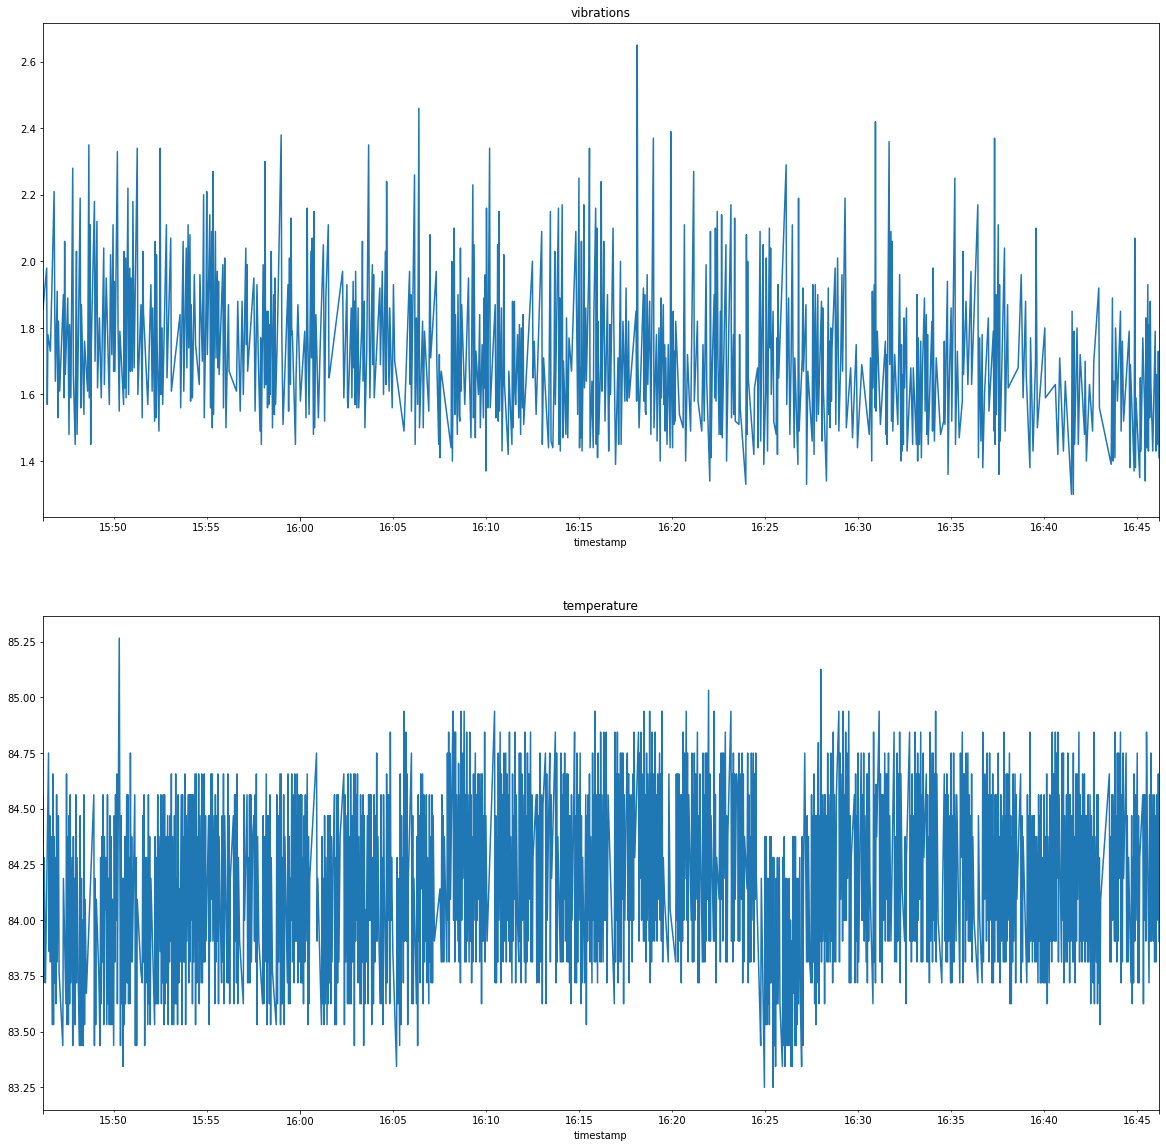

1024.0


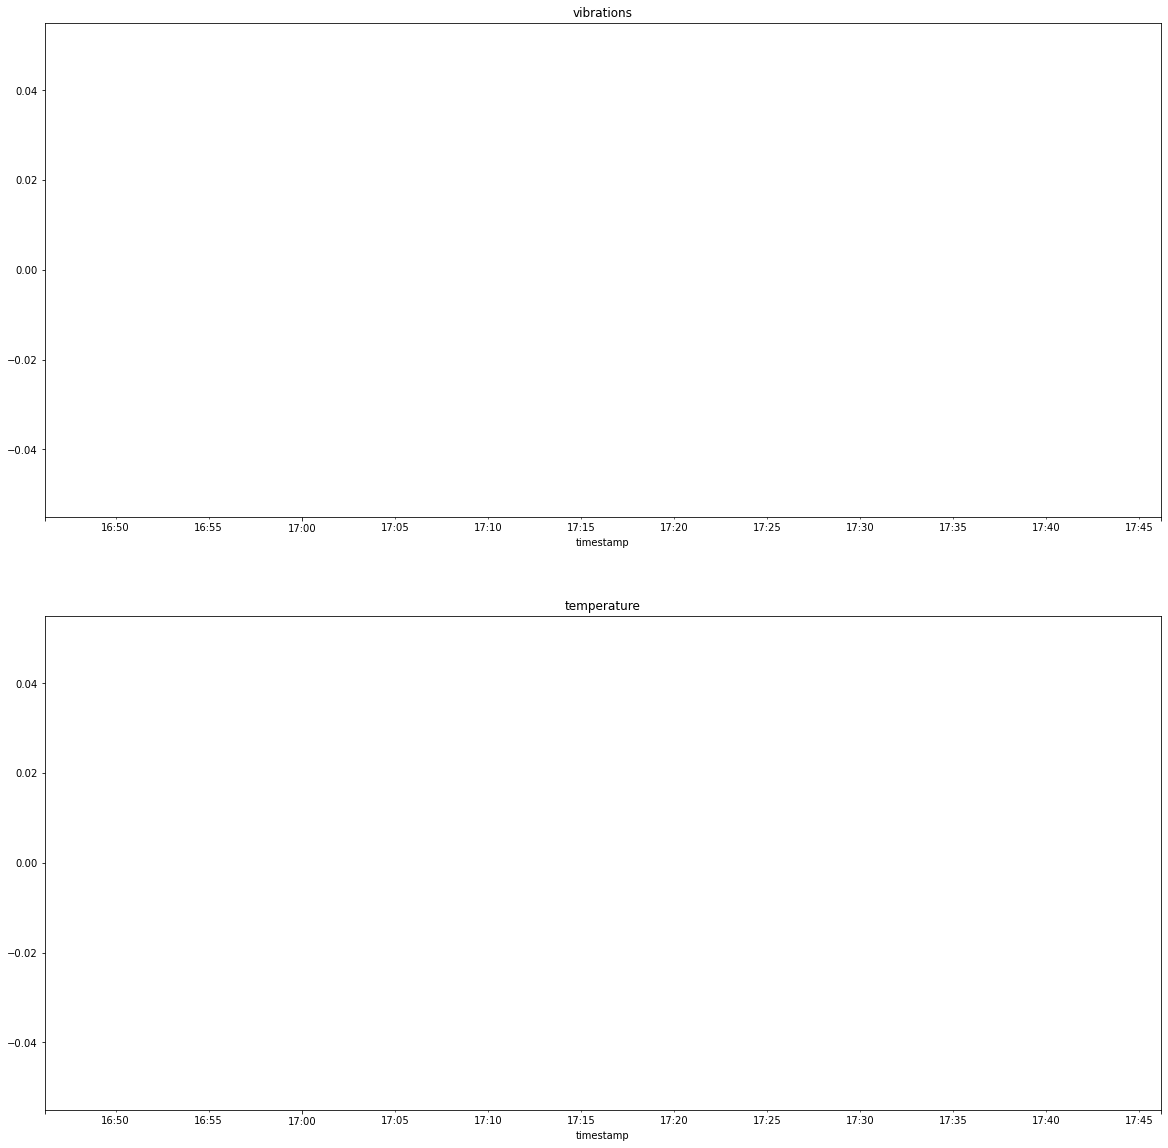

1738.0


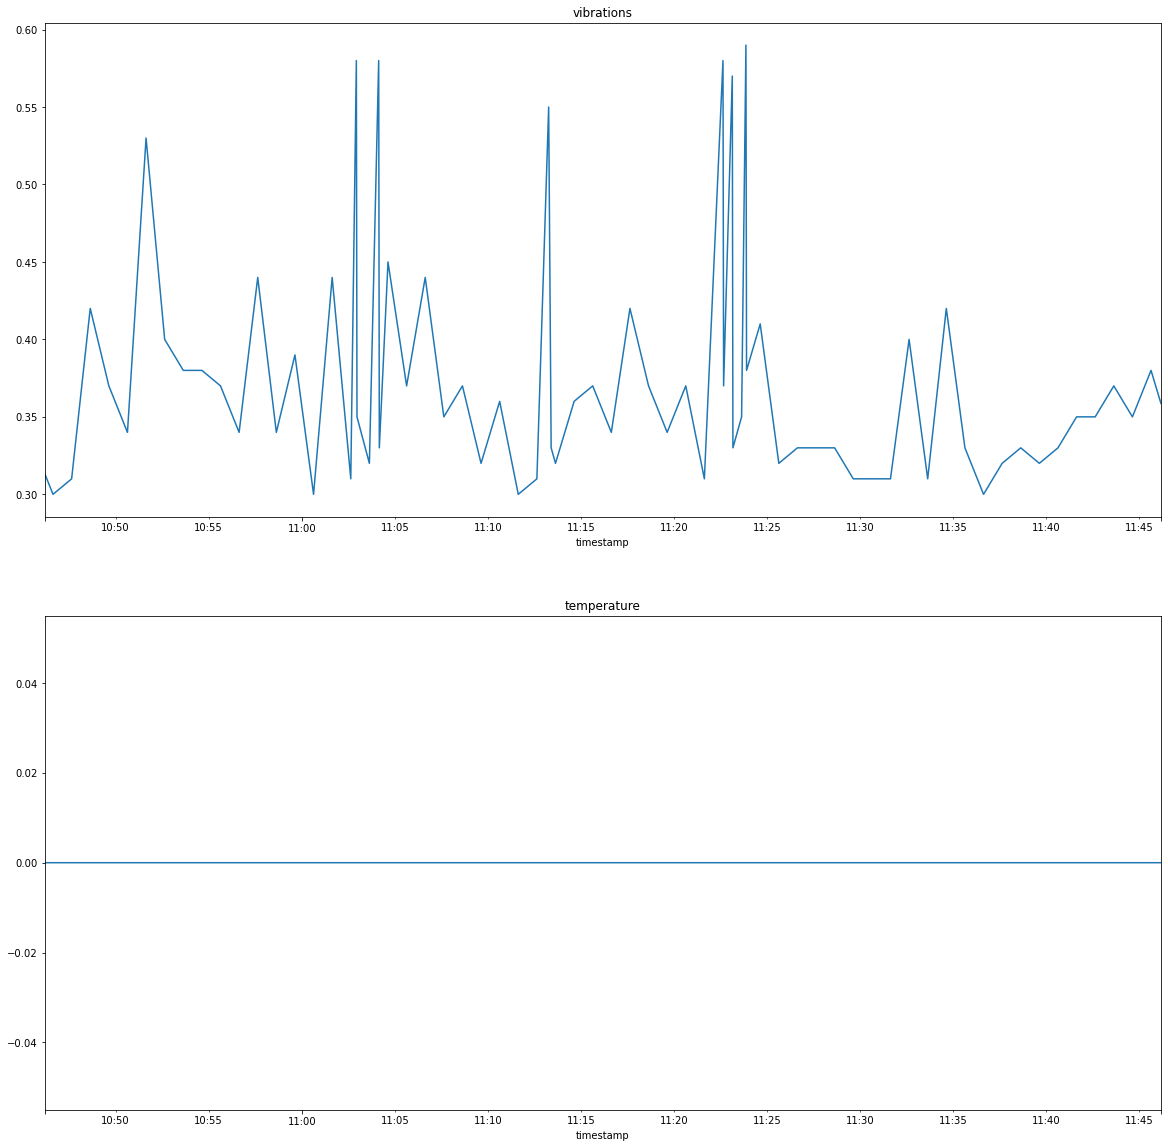

In [14]:
verbose_names = [15, 1024, 1738]

for name, group in df_groups:
    if name in verbose_names:
        print(name)
        tools.plot_timeseries_data(group, style=None)

Calculate the features for each group (ref. https://www.jvejournals.com/article/21622)

In [15]:
VALIDITY_THRESHOLD = 0.4

non_valid_counter = 0

names_list = list()
features_list = list()
for name, group in df_groups:
    # Calculate number of NaNs to check validity and igniore group
    nans_count = group.isna().sum().sum()
    invalid_part = (nans_count / (group.shape[0]*group.shape[1]))
    # Skip feature extraction when the percentage of invalid values is too high
    if invalid_part > VALIDITY_THRESHOLD:
        non_valid_counter += 1
        if name in verbose_names:
            print("Group {} ignored on validity check.".format(name))
        continue

    # Drop NaNs in the vibration data
    group.dropna(subset=['vibration'], inplace=True)

    # Calculate velocity signal
    velocity = integrate.cumulative_trapezoid(group['vibration'],
                                              x=group.index.astype(np.int64) / 10**9)
    # Extract features
    features = {
        'temperature': group['temperature'].mean(),
        'acc_rms': np.sqrt(group['vibration'].pow(2).mean()),
        'acc_kurtosis': group['vibration'].kurt(),
        'acc_peak_to_peak': group['vibration'].max() - group['vibration'].min(),
        'vel_rms': np.sqrt(np.square(velocity).mean())
    }
    names_list.append(name)
    features_list.append(features)
    if name in verbose_names:
        print("Group {}: {}".format(name, features))

print("Ignored {} groups due to too many missing values.".format(non_valid_counter))

C:\Users\Krzysztof\AppData\Local\Temp\ipykernel_5112\3150383784.py:23: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x=group.index.astype(np.int64) / 10**9)


Group 15.0: {'temperature': 84.17076833333333, 'acc_rms': 1.721727894877103, 'acc_kurtosis': 0.7766202545288725, 'acc_peak_to_peak': 1.3499999999999999, 'vel_rms': 3607.141931422105}
Group 1024.0 ignored on validity check.
Group 1738.0: {'temperature': 0.0, 'acc_rms': 0.3655085598756443, 'acc_kurtosis': 3.7463431754299985, 'acc_peak_to_peak': 0.29, 'vel_rms': 766.1723184944102}
Ignored 501 groups due to too many missing values.


Create DataFrame from features list

In [16]:
df_features = pd.DataFrame(data=features_list)

Calculate features importance based on normalized variance (versus mean values)

In [17]:
feature_importance = (df_features.var() / df_features.mean()).sort_values(ascending=False)
print("Feature importance:\n{}".format(feature_importance))

Feature importance:
vel_rms             886.372248
temperature          55.252809
acc_kurtosis          2.183073
acc_rms               0.428160
acc_peak_to_peak      0.284331
dtype: float64


Plot most important features that are nice to observe on plot

<AxesSubplot:xlabel='acc_peak_to_peak', ylabel='vel_rms'>

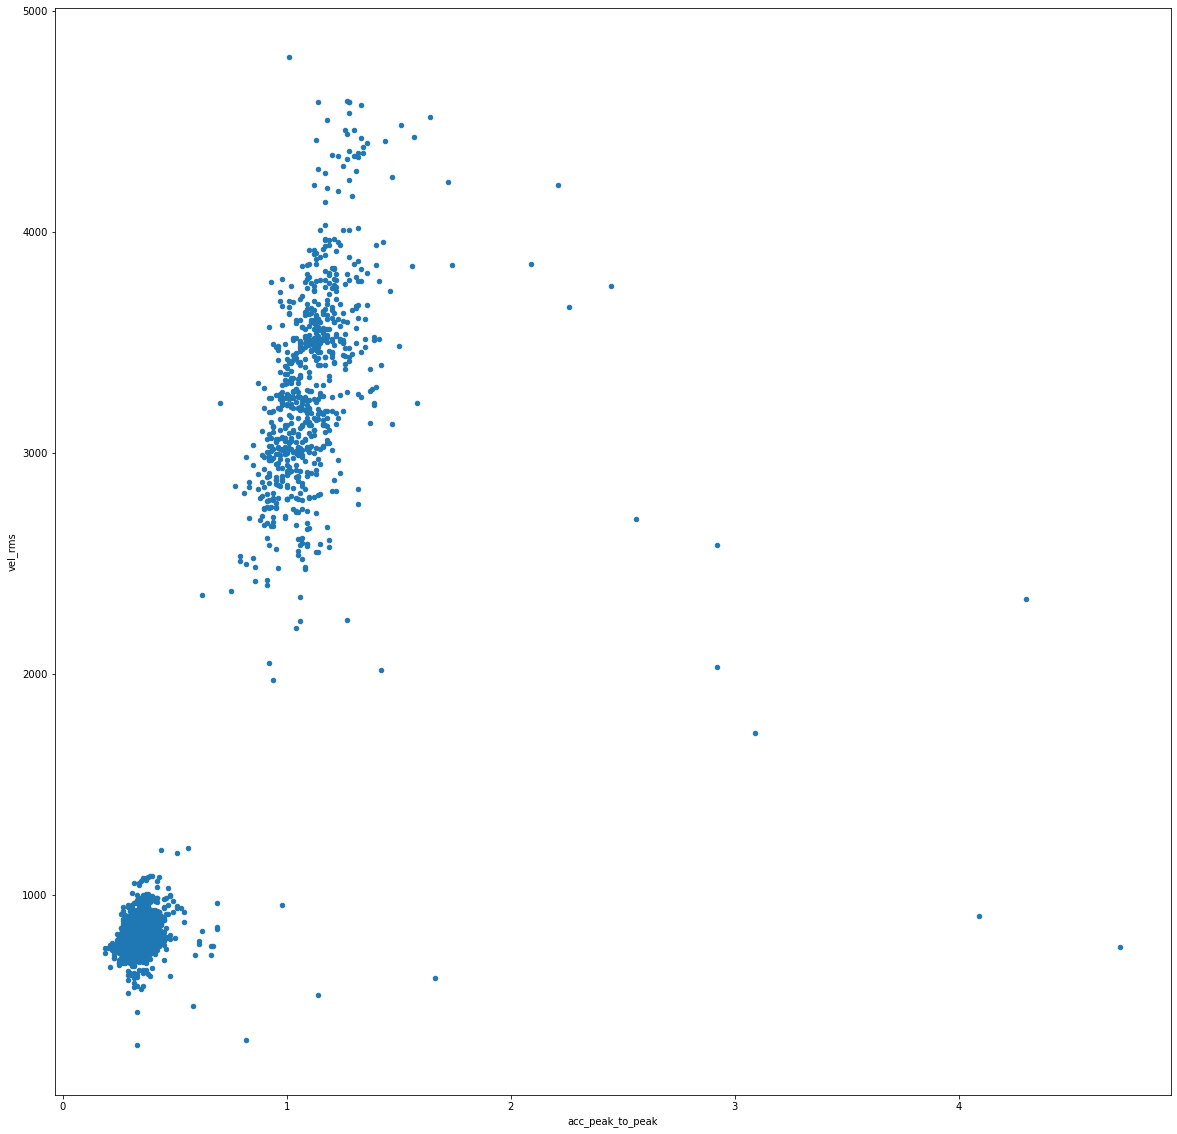

In [58]:
df_features.plot.scatter(x=df_features.index[3], y=df_features.index[4])

Cluster the data using DBSCAN algorithm

In [65]:
scaled_features = StandardScaler().fit_transform(df_features)
df_scaled_features = pd.DataFrame(scaled_features, index=df_features.index, 
                                  columns=df_features.columns)

db = DBSCAN(eps=1.5, min_samples=50).fit(scaled_features)

clusters = pd.DataFrame(db.fit_predict(scaled_features))
clusters_num = len(np.unique(clusters.where(clusters >= 0).dropna()))
print("Number of clusters: {}".format(clusters_num))
outliers_num = clusters.where(clusters == -1).dropna().shape[0]
print("Outliers num (noisy data): {}".format(outliers_num))

Number of clusters: 2
Outliers num (noisy data): 12


Plot the results of clustering

<AxesSubplot:xlabel='acc_peak_to_peak', ylabel='vel_rms'>

<Figure size 1440x1440 with 0 Axes>

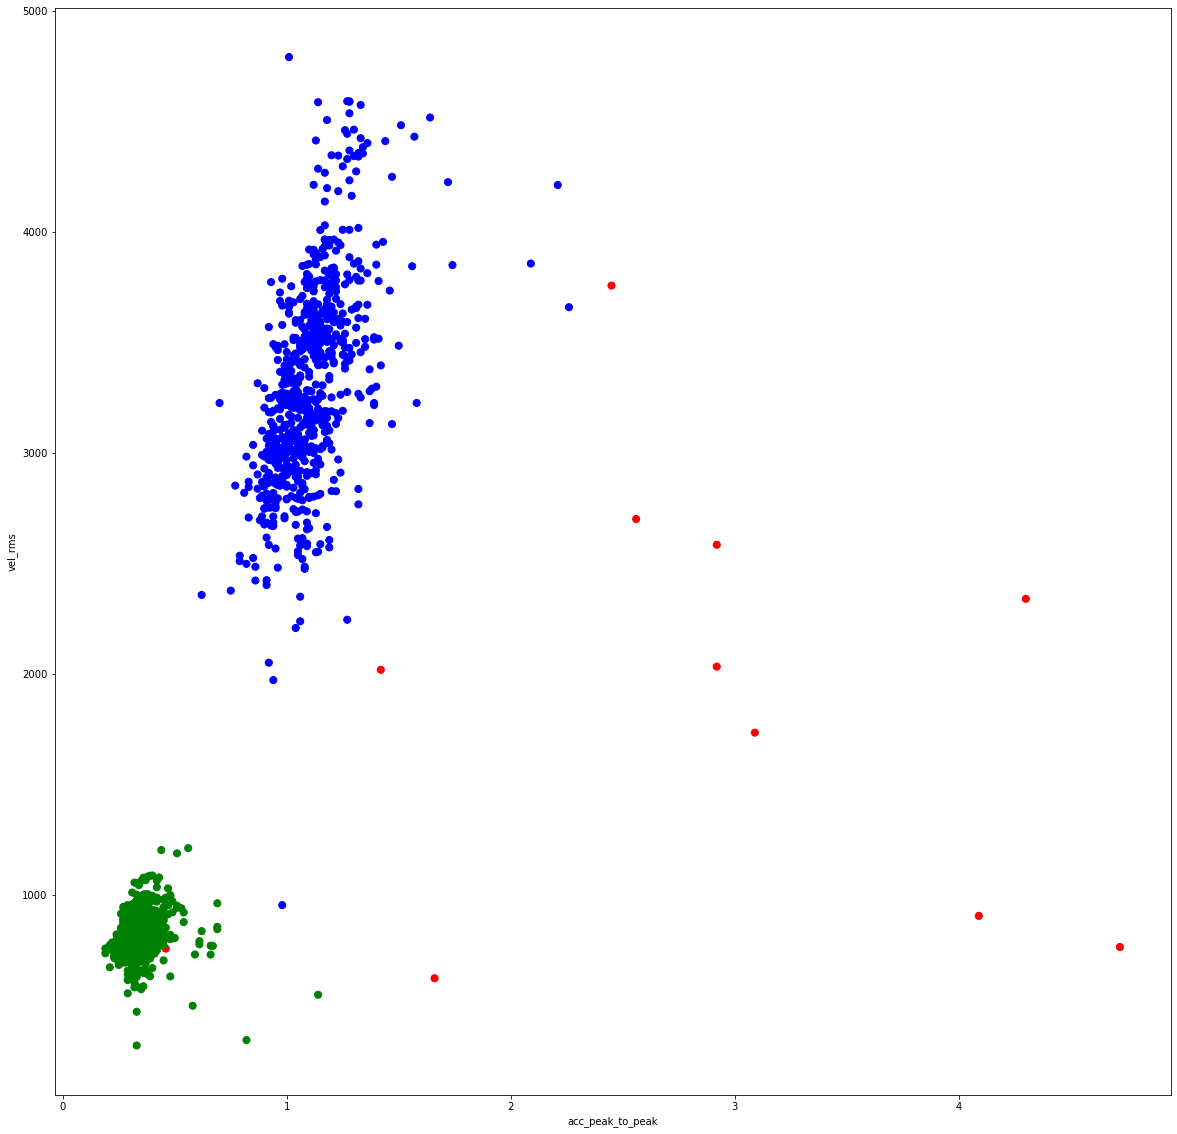

In [66]:
colors = {
    0: 'green',
    1: 'blue',
    -1: 'red'
}

fig = plt.figure()
df_features.plot.scatter(x=df_features.index[3], y=df_features.index[4], c=clusters.squeeze().map(colors), s=50)

Save model and related feature transforms for later use in model implementation on Cloud

In [72]:
import pickle
import os

model_filename = os.path.join('model', 'anomaly_detection_model.sav')
pickle.dump(db, open(model_filename, 'wb'))

feature_scaling = {
    'variance': df_features.var(),
    'mean': df_features.mean()
}
print(feature_scaling)
scaling_filename = os.path.join('model', 'feature_scaling.sav')
pickle.dump(feature_scaling, open(scaling_filename, 'wb'))

{'variance': temperature         1.626423e+03
acc_rms             3.501571e-01
acc_kurtosis        4.645085e+00
acc_peak_to_peak    1.749691e-01
vel_rms             1.485945e+06
dtype: float64, 'mean': temperature           29.436018
acc_rms                0.817819
acc_kurtosis           2.127773
acc_peak_to_peak       0.615371
vel_rms             1676.434194
dtype: float64}
